In [12]:
!pip install numba
import numpy as np
import cv2
import imageio
import os
from numba import njit
import matplotlib.pyplot as plt

In [13]:
def convolve(image, kernel):
    """
    Optimized convolution using NumPy einsum for performance.
    """
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    img_h, img_w = image.shape
    output = np.zeros((img_h, img_w), dtype=np.float32)

    # Extract patches using NumPy strides
    patches = np.lib.stride_tricks.sliding_window_view(padded, (k_h, k_w))

    # Perform element-wise multiplication and sum using einsum
    output = np.einsum('ijkl,kl->ij', patches, kernel)

    return output

def compute_energy(gray):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=np.float32)

    grad_x = convolve(gray.astype(np.float32), sobel_x)
    grad_y = convolve(gray.astype(np.float32), sobel_y)

    return np.sqrt(grad_x**2 + grad_y**2)


In [14]:
@njit
def find_seam(energy):
    """
    Find the vertical seam with minimum energy using dynamic programming.
    Returns an array of column indices (one per row).
    """
    h, w = energy.shape
    dp = energy.copy()
    backtrack = np.zeros_like(dp, dtype=np.int32)

    # Build the DP table. Each cell accumulates the minimum energy from the top.
    for i in range(1, h):
        for j in range(0, w):
            # Handle the left edge
            if j == 0:
                idx = np.argmin(dp[i-1, j:j+2])
                min_energy = dp[i-1, idx+j]
                backtrack[i, j] = idx + j
            # Handle the right edge
            elif j == w - 1:
                idx = np.argmin(dp[i-1, j-1:j+1])
                min_energy = dp[i-1, idx+j-1]
                backtrack[i, j] = idx + j - 1
            else:
                idx = np.argmin(dp[i-1, j-1:j+2])
                min_energy = dp[i-1, idx+j-1]
                backtrack[i, j] = idx + j - 1
            dp[i, j] += min_energy

    # Backtrack from the bottom row to find the seam
    seam = np.zeros(h, dtype=np.int32)
    seam[-1] = np.argmin(dp[-1])
    for i in range(h-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]
    return seam

In [15]:
def remove_seam(image, seam):
    """
    Remove the vertical seam from the image.
    Works for both color and grayscale images.
    """
    h, w = image.shape[:2]
    if image.ndim == 3:
        output = np.zeros((h, w - 1, 3), dtype=image.dtype)
    else:
        output = np.zeros((h, w - 1), dtype=image.dtype)

    for i in range(h):
        j = seam[i]
        # Remove the j-th column for row i
        if image.ndim == 3:
            output[i, :, 0] = np.delete(image[i, :, 0], j)
            output[i, :, 1] = np.delete(image[i, :, 1], j)
            output[i, :, 2] = np.delete(image[i, :, 2], j)
        else:
            output[i, :] = np.delete(image[i, :], j)
    return output


In [16]:
def mark_seam(image, seam, color=(255, 0, 0)):
    """
    Mark the seam on a copy of the image.
    The seam pixels (and optionally their neighbors) are colored.
    """
    image_marked = image.copy()
    h, w = image.shape[:2]
    for i in range(h):
        j = seam[i]
        if j >= 0 and j < w:
            image_marked[i, j] = color
            # Optionally mark adjacent pixels to make the seam more visible:
            if j > 0:
                image_marked[i, j - 1] = color
            if j < w - 1:
                image_marked[i, j + 1] = color
    return image_marked

In [17]:
def seam_carve(image, num_seams):
    """
    Iteratively remove vertical seams from the image.
    Returns the final carved image, a history list of the marked images, and a list of all removed seams.
    """
    history = []  # To store intermediate images with the seam highlighted
    seams = []  # To store all removed seams for later visualization
    current_image = image.copy()

    for _ in range(num_seams):
        # Convert to grayscale if needed (for energy computation)
        gray = cv2.cvtColor(current_image, cv2.COLOR_RGB2GRAY)
        energy_map = compute_energy(gray)
        seam = find_seam(energy_map)

        # Store seam for later visualization
        seams.append(seam)

        # Mark seam on the current image (for visualization)
        marked = mark_seam(current_image, seam)
        history.append(marked)

        # Remove the seam to get a new image
        current_image = remove_seam(current_image, seam)

    return current_image, history, seams

In [18]:
def draw_seams(image, seams):
    """Draws all seams on the image before removal."""
    seam_image = image.copy()
    for seam in seams:
        for row, col in enumerate(seam):
            seam_image[row, col] = [255, 0, 0]  # Mark seam in red
    return seam_image

In [19]:
image_paths = os.listdir('data/')
for img in image_paths:
    if img.endswith('.jpg'):
        image_path = os.path.join('data/', img)
        image = imageio.imread(image_path)

        # Ensure the image is in RGB format
        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        num_seams = 100

        # Perform seam carving while keeping track of seams
        final_image, history, seams = seam_carve(image, num_seams)

        # Draw seams on the original image before removal
        seam_image = draw_seams(image, seams)

        # Convert to BGR and save
        cv2.imwrite(f'seams/{img}', cv2.cvtColor(seam_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(f'carved/{img}', cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))

<ipython-input-19-1e391578ab14>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [31]:
import ipywidgets as widgets
from IPython.display import display

def display_history_colab(history):
    """
    Displays the seam carving process using an interactive slider in Google Colab.
    """
    def show_frame(step):
        plt.figure(figsize=(6, 6))
        plt.imshow(history[step])  # Convert BGR to RGB for correct colors
        plt.axis("off")
        plt.title(f"Seam Carving Step {step}/{len(history)-1}")
        plt.show()

    # Create an interactive slider
    slider = widgets.IntSlider(min=0, max=len(history)-1, step=1, description="Step:")

    # Correct way to display the interactive output
    output = widgets.interactive_output(show_frame, {'step': slider})

    # Display the slider and output together
    display(slider, output)

display_history_colab(history)

IntSlider(value=0, description='Step:', max=99)

Output()

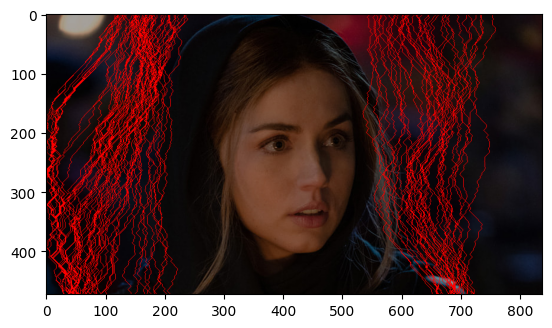

In [20]:
plt.imshow(seam_image)

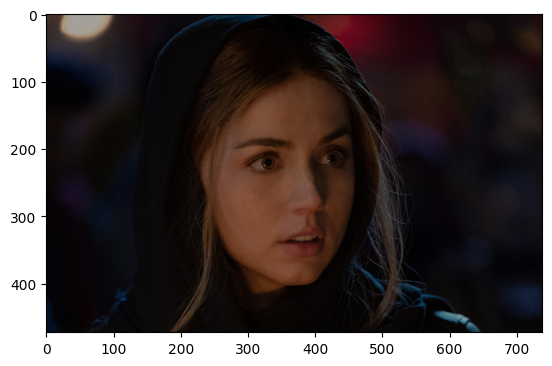

In [21]:
plt.imshow(final_image)